In [62]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import date
from scipy.stats import norm 
import os

# Custom Libraries -->
import importlib

import src
importlib.reload(src)

from src.option import OptionContract
importlib.reload(src.option)
from src.portfolio import Portfolio
importlib.reload(src.portfolio)
from src.simulation import MonteCarloSimulation
importlib.reload(src.simulation)
from src.tradier import Tradier
importlib.reload(src.tradier)
from src.algorithms import binarySearch
importlib.reload(src.algorithms)


<module 'src.algorithms' from 'c:\\Users\\trevo\\OneDrive\\Documents\\projects\\yieldmax\\src\\algorithms.py'>

In [99]:
%load_ext dotenv
%dotenv
access_token = os.environ.get("access_token")

SYMBOL = "UVIX"
START_DATE = "2023-01-01"
END_DATE = "2023-12-30"

tradier = Tradier(access_token)

The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv


In [100]:
daily_std = tradier.getVolatility(SYMBOL, START_DATE, END_DATE)
print("Daily STD:", daily_std)

Daily STD: 0.6044260284269697


In [101]:
expiration_dates = tradier.getSymbolExpirationDates(SYMBOL)
print("Expiration Dates:", expiration_dates)

expiration = expiration_dates[8]
today = date.today()
NUM_OF_DAYS = np.busday_count(today, expiration)

Expiration Dates: ['2024-01-12', '2024-01-19', '2024-01-19', '2024-01-19', '2024-01-26', '2024-02-02', '2024-02-09', '2024-02-16', '2024-02-23', '2024-03-15', '2024-03-15', '2024-04-19', '2024-05-17', '2024-06-21', '2024-06-21', '2024-06-21', '2024-09-20', '2025-01-17', '2025-01-17', '2025-01-17', '2026-01-16', '2026-01-16']


In [102]:
json_response = tradier.getOptionChain(SYMBOL, expiration)

call_strikes = [entry['strike'] if entry['option_type'] == "call" else None for entry in json_response['options']['option']]
call_bids = [entry['ask'] if entry['option_type'] == "call" else None for entry in json_response['options']['option']]
call_asks = [entry['bid'] if entry['option_type'] == "call" else None for entry in json_response['options']['option']]

put_strikes = [entry['strike'] if entry['option_type'] == "put" else None for entry in json_response['options']['option']]
put_bids = [entry['bid'] if entry['option_type'] == "put" else None for entry in json_response['options']['option']]
put_asks = [entry['ask'] if entry['option_type'] == "put" else None for entry in json_response['options']['option']]

In [103]:
price = tradier.getMarketPrice(SYMBOL)
print("Price:", price)

Price: 12.76


Adjusted Standard Deviation: 3.5243790957500587
Call ATM:  13.0 Put ATM:  13.0 OTM:  16.5
Cost per trade:  5.34
Intersection: $ 11.186862712749823


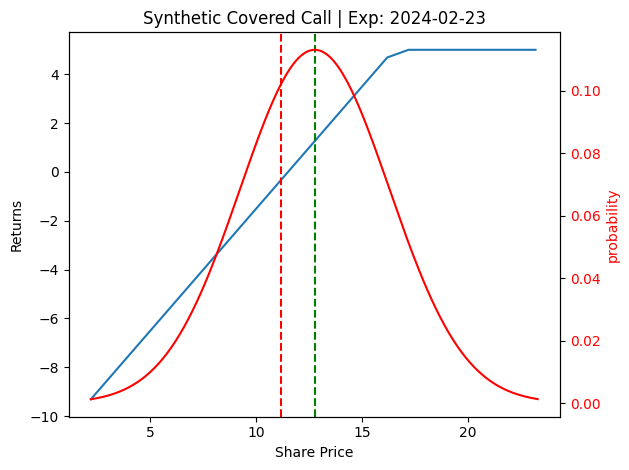

In [104]:
std = daily_std * np.sqrt(NUM_OF_DAYS)
print("Adjusted Standard Deviation:", std)

STD_WIDTH = 3
prices = np.arange(price - STD_WIDTH * std, price + STD_WIDTH * std, 1)

def getStrikeNearPrice(strikes: list, price: float):
    for i in range(len(strikes)):
        if strikes[i] != None and strikes[i] > price:
            return strikes[i], i

C_ATM_STRIKE, CALL_ATM_INDEX = getStrikeNearPrice(call_strikes, price)
C_ATM_PREMIUM = call_asks[CALL_ATM_INDEX]

P_ATM_STRIKE, PUT_ATM_INDEX = getStrikeNearPrice(put_strikes, price)
P_ATM_PREMIUM = put_bids[PUT_ATM_INDEX]

C_OTM_STRIKE, CALL_OTM_INDEX = getStrikeNearPrice(call_strikes, price + std)
C_OTM_PREMIUM = call_bids[CALL_OTM_INDEX]

print("Call ATM: ", C_ATM_STRIKE, "Put ATM: ", P_ATM_STRIKE, "OTM: ", C_OTM_STRIKE)

covered_call_strat = Portfolio([
    # ATM LONG CALL
    OptionContract(C_ATM_STRIKE, C_ATM_PREMIUM, 'Call', 'Long'),
    
    # ATM SHORT PUT
    OptionContract(P_ATM_STRIKE, P_ATM_PREMIUM, 'Put', 'Short'),
    
    # OTM SHORT CALL
    OptionContract(C_OTM_STRIKE, C_OTM_PREMIUM, 'Call', 'Short'),
])

fig, ax1 = plt.subplots()
ax1.title.set_text("Synthetic Covered Call | Exp: " + expiration)

values = covered_call_strat.getPriceInformation(prices)

# Binary search to find 0 in values
intersection = binarySearch(values, 0)

print("Intersection: $", prices[intersection])

ax1.plot(prices, values)
ax1.set_xlabel('Share Price')
ax1.set_ylabel('Returns', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.axvline(x=prices[intersection], color='r', linestyle='--')
ax1.axvline(x=price, color='g', linestyle='--')

ax2 = ax1.twinx()

x_axis = np.arange(price-STD_WIDTH*std, price+STD_WIDTH*std, 0.1) 

ax2.plot(x_axis, norm.pdf(x_axis, price, std), color='r')
ax2.set_ylabel('probability', color='r')
ax2.tick_params(axis='y', labelcolor='r')

fig.tight_layout()
plt.show()

In [105]:
import plotly.graph_objects as go

# Optimal Allocation Optimization
STARTING_BALANCE = 100_000
sample_size = 1000
NUM_TRIALS = 100

seed = np.random.randint(0, 1000)
np.random.seed(seed)

option_allocations = np.random.uniform(0, 1, sample_size)
cash_allocations = [1 - x for x in option_allocations]


In [106]:
Markowitz = pd.DataFrame(columns=['Index', 'Option Allocation',
                  'Cash Allocation', 'Returns', 'Volatility'])
MaxDrawdown = pd.DataFrame(columns=['Index', 'Option Allocation',
                  'Cash Allocation', 'Returns', 'Max Drawdown'])

for i, (option_allocation, cash_allocation) in enumerate(zip(option_allocations, cash_allocations)):
    cash_allocation = 1 - option_allocation

    simulation = MonteCarloSimulation(
        covered_call_strat, NUM_TRIALS, NUM_OF_DAYS, price, daily_std, STARTING_BALANCE)

    (result, volatility) = simulation.simulate(cash_allocation, option_allocation)

    temp = pd.DataFrame({
        'Index': i,
        'Option Allocation': option_allocation,
        'Cash Allocation': cash_allocation,
        'Returns': result,
        'Volatility': volatility,
    }, index=[0])

    Markowitz = pd.concat([Markowitz, temp])

    (result, maxDrawdown) = simulation.run(cash_allocation, option_allocation, display=False)

    temp = pd.DataFrame({
        'Index': i,
        'Option Allocation': option_allocation,
        'Cash Allocation': cash_allocation,
        'Returns': result,
        'Max Drawdown': maxDrawdown,
    }, index=[0])

    MaxDrawdown = pd.concat([MaxDrawdown, temp])

In [109]:
fig = go.Figure()
fig.add_trace(go.Scatter(
    # x=df['Volatility'] / np.sqrt(NUM_OF_DAYS),
    x=Markowitz['Volatility'],
    y=Markowitz['Returns'],
    mode='markers',
    marker=dict(
        color=Markowitz['Option Allocation'],
        colorscale='RdBu',
        size=7,
        colorbar=dict(title="Option<br>Allocation")
    )
))
fig.update_layout(
    template="plotly_white",
    title="Monte Carlo Simulation of " + SYMBOL + " | Seed: " + str(seed) + " | Trails: " + str(NUM_TRIALS),
    xaxis_title="Risk Volatility (Standard Deviation)",
    yaxis_title="Expected Return",
)
fig.update_layout(coloraxis_colorbar=dict(title="Option Allocation"))

In [108]:
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=MaxDrawdown['Max Drawdown'],
    y=MaxDrawdown['Returns'],
    mode='markers',
    marker=dict(
        color=MaxDrawdown['Option Allocation'],
        colorscale='RdBu',
        size=7,
        colorbar=dict(title="Option<br>Allocation")
    )
))
fig.update_layout(
    template="plotly_white",
    title="Monte Carlo Simulation of " + SYMBOL +
    " | Seed: " + str(seed),
    xaxis_title="Max Drawdown",
    yaxis_title="Returns",
)
fig.update_layout(coloraxis_colorbar=dict(title="Option Allocation"))